In [1]:
from utility import * 
data_dir = "dataset"
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder as enc , LabelEncoder as le
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import string
from tensorflow.keras.utils import plot_model

In [2]:
train_lines = get_lines(data_dir + "train.txt")
train_samples = preprocess_text_with_line_number(filename=data_dir + "train.txt")
test_samples = preprocess_text_with_line_number(filename=data_dir + "test.txt")
val_samples = preprocess_text_with_line_number(filename=data_dir + "dev.txt")
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()
encoder = enc(sparse=False)
train_labels = encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels = encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
val_labels = encoder.transform(val_df["target"].to_numpy().reshape(-1,1))

In [3]:
hub_embeding_layer =  hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable = False)
alphabet = string.ascii_lowercase + string.digits + string.punctuation
num_char_tokens = len(alphabet) + 2
def split_chars(text):
    return " ".join(list(text))
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
char_vectorizer = layers.TextVectorization(max_tokens=num_char_tokens,output_sequence_length = 290)
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim = 25,
                                  mask_zero = True,
                                  name = "char_embed")

In [4]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
train_line_num_one_hot = tf.one_hot(train_df["line_num"].to_numpy(),depth = 15)
val_line_num_one_hot = tf.one_hot(val_df["line_num"].to_numpy(),depth = 15)
test_line_num_one_hot = tf.one_hot(test_df["line_num"].to_numpy(),depth = 15)
train_line_total_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth = 20)
val_line_total_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth = 20)
test_line_total_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth = 20)

In [6]:
token_inputs = layers.Input(shape = [],dtype = tf.string , name = "Token_input")
token_embeddings = hub_embeding_layer(token_inputs)
token_outputs = layers.Dense(128,activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

char_inputs = layers.Input(shape = (1,),dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

line_num_inputs = layers.Input(shape = [15,],dtype = tf.float32,name = "line_num_inputs")
line_dense = layers.Dense(32,activation = "relu")(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs,line_dense)

total_lines_inputs = layers.Input(shape = [20,],dtype = tf.float32,name = "total_lines_inputs")
total_lines_dense = layers.Dense(32,activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_dense)


combined_embedding = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output,char_model.output])

z = layers.Dense(256,activation = "relu")(combined_embedding)
z = layers.Dropout(0.5)(z)


tribrid_embedding = layers.Concatenate(name = "char_token_positional_embedding")([line_num_model.output,total_lines_model.output,z])

output_layer = layers.Dense(5,activation = "softmax")(tribrid_embedding)


model_5 = tf.keras.Model(inputs = [line_num_model.input,total_lines_model.input,token_model.input,char_model.input],outputs = output_layer)

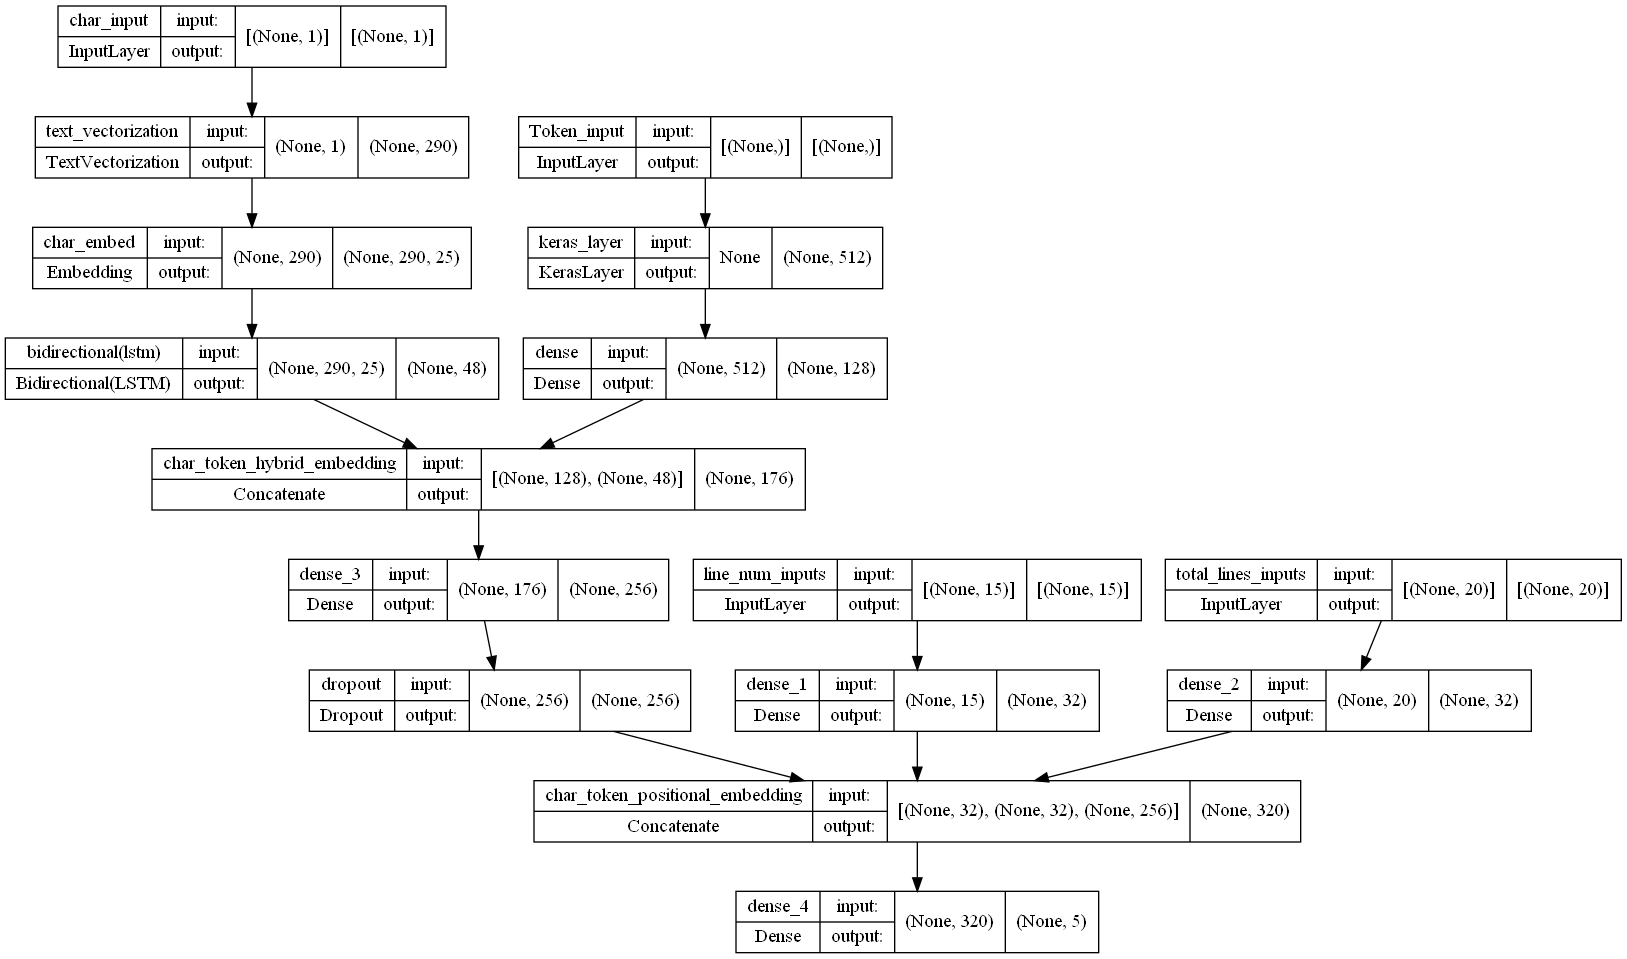

In [7]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer = "adam",metrics = ["accuracy"])
plot_model(model_5,show_shapes=True)

In [8]:
training_data = tf.data.Dataset.from_tensor_slices((train_line_num_one_hot,train_line_total_one_hot,train_sentences,train_chars))
training_labels = tf.data.Dataset.from_tensor_slices(train_labels)
training_dataset = tf.data.Dataset.zip((training_data,training_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

testing_data = tf.data.Dataset.from_tensor_slices((test_line_num_one_hot,test_line_total_one_hot,test_sentences,test_chars))
testing_labels = tf.data.Dataset.from_tensor_slices(test_labels)
testing_dataset = tf.data.Dataset.zip((testing_data,testing_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((val_line_num_one_hot,val_line_total_one_hot,val_sentences,val_chars))
validation_labels = tf.data.Dataset.from_tensor_slices(val_labels)
validation_dataset = tf.data.Dataset.zip((validation_data,validation_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
training_dataset,validation_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model5 = model_5.fit(training_dataset,
                             steps_per_epoch = int(len(training_dataset)),
                             epochs = 5,
                             validation_data = validation_dataset,
                             validation_steps = int(len(validation_dataset)))

In [ ]:
model_5.save("skimlit_tribrid_20k_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_20k_0.1_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_20k_0.1_model\assets


In [2]:
loaded_model = tf.keras.models.load_model("model")

In [ ]:

loaded_model_prob = model_5.predict(validation_dataset)
loaded_preds = tf.argmax(loaded_model_prob,axis = 1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [ ]:
labelenc = le()
train_labels_encoded = labelenc.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = labelenc.transform(test_df["target"].to_numpy())
val_labels_encoded = labelenc.transform(val_df["target"].to_numpy())
calculate_results(y_true = val_labels_encoded,y_pred = loaded_preds)

{'accuracy': 84.16854230107242,
 'precision': 0.8454170341714997,
 'recall': 0.8416854230107242,
 'f1': 0.83776214266753}